#0: ライブラリのインポート&デバイス設定

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50
from torch.utils.data import random_split

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda'

#1: データ前処理

In [4]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(), #画像をランダムに反転
    transforms.ColorJitter(), #色合いや明るさをランダムに変化
    transforms.RandomRotation(10), #画像を最大±10度の範囲でランダムに回転
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

In [5]:
transform_val = transforms.Compose([
    transforms.ToTensor(), #画像データをPyTorchのテンソルに変換
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)) #正規化
])

#2 	データセットのダウンロードとデータローダーの作成

In [6]:
# 訓練用データローダーの作成
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Early Stoppingのパラメータ設定
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0

# 学習データを90%/10%に分割
train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
train_subset, val_subset = random_split(trainset, [train_size, val_size])

# 訓練用データローダーを定義
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

# テスト用データセットの作成
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=4)

100%|██████████| 170M/170M [00:05<00:00, 28.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Files already downloaded and verified


#3 モデルの選定

a. アーキテクチャの選択

In [7]:
# 事前学習済みのResNet50モデルをロード
model = resnet50(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 98.3MB/s]


b. 転移学習

In [8]:
# ResNet50の最終層の入力サイズを取得
num_ftrs = model.fc.in_features
# CIFAR-10は10クラス分類のため、最終層を出力ユニット10に変更
model.fc = nn.Linear(num_ftrs, 10)
# モデルをGPUに転送
model = model.to(device)

#4 学習方法

a. 損失関数の選択

In [9]:
criterion = nn.CrossEntropyLoss()
# クロスエントロピー損失を用いる。多クラス分類に適した損失関数

b. 正則化

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
# 確率的勾配降下法（SGD）

c. 学習スケジューリング

In [11]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# 5エポックごとに学習率を10%に減衰させる

In [12]:
num_epochs = 100

# ロスと正解率の履歴を保存するリスト
train_loss_history = []
train_accs_history = []
val_loss_history = []
val_accs_history = []

for epoch in range(num_epochs):
    model.train()  # 訓練モードに切り替え
    running_loss = 0.0
    running_corrects = 0  # 正解数を累積する変数
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # 勾配を初期化
        outputs = model(inputs)  # 順伝播
        loss = criterion(outputs, labels)  # 損失計算
        loss.backward()  # 逆伝播
        optimizer.step()  # パラメータ更新

        running_loss += loss.item() * inputs.size(0)  # バッチ損失を累積（サンプル数で重み付け）

        # 予測クラスを計算し、正解数をカウント
        preds = torch.argmax(outputs, dim=1)
        running_corrects += torch.sum(preds == labels).item()

    # 学習率の更新
    scheduler.step()

    # エポック全体の平均損失と正解率を計算
    epoch_loss = running_loss / len(trainset)
    epoch_acc = running_corrects / len(trainset)
    train_loss_history.append(epoch_loss)
    train_accs_history.append(epoch_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    # 検証フェーズ
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        for inputs_val, labels_val in valloader:
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
            outputs_val = model(inputs_val)
            loss_val = criterion(outputs_val, labels_val)
            val_loss += loss_val.item() * inputs_val.size(0)

            # 検証用の正解数をカウント
            val_preds = torch.argmax(outputs_val, dim=1)
            val_corrects += torch.sum(val_preds == labels_val).item()

    val_loss /= len(valloader.dataset)
    val_acc = val_corrects / len(valloader.dataset)
    val_loss_history.append(val_loss)
    val_accs_history.append(val_acc)

    print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

    # Early Stoppingの処理（検証損失で判断）
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()  # 最良モデルを保存
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:  # patience=10の場合
            print(f'Early stopping at epoch {epoch+1}')
            model.load_state_dict(best_model_state)
            break

Epoch 1/100, Loss: 0.8917, Accuracy: 0.5886
Epoch 1, Validation Loss: 0.7110, Validation Accuracy: 0.7630
Epoch 2/100, Loss: 0.5005, Accuracy: 0.7292
Epoch 2, Validation Loss: 0.5510, Validation Accuracy: 0.8084
Epoch 3/100, Loss: 0.4058, Accuracy: 0.7593
Epoch 3, Validation Loss: 0.5273, Validation Accuracy: 0.8172
Epoch 4/100, Loss: 0.3383, Accuracy: 0.7831
Epoch 4, Validation Loss: 0.4905, Validation Accuracy: 0.8358
Epoch 5/100, Loss: 0.2856, Accuracy: 0.8028
Epoch 5, Validation Loss: 0.4756, Validation Accuracy: 0.8362
Epoch 6/100, Loss: 0.1982, Accuracy: 0.8327
Epoch 6, Validation Loss: 0.4358, Validation Accuracy: 0.8602
Epoch 7/100, Loss: 0.1645, Accuracy: 0.8442
Epoch 7, Validation Loss: 0.4644, Validation Accuracy: 0.8528
Epoch 8/100, Loss: 0.1502, Accuracy: 0.8494
Epoch 8, Validation Loss: 0.4544, Validation Accuracy: 0.8576
Epoch 9/100, Loss: 0.1331, Accuracy: 0.8543
Epoch 9, Validation Loss: 0.4570, Validation Accuracy: 0.8616
Epoch 10/100, Loss: 0.1228, Accuracy: 0.8588
E

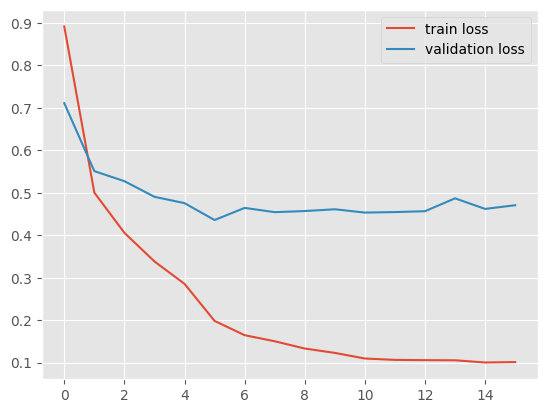

In [13]:
plt.style.use("ggplot")
plt.plot(train_loss_history, label="train loss")
plt.plot(val_loss_history, label="validation loss")
plt.title('Train Loss over Epochs')
plt.legend()

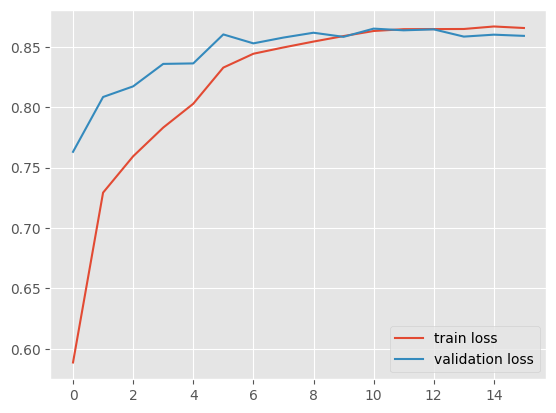

In [14]:
plt.style.use("ggplot")
plt.plot(train_accs_history, label="train accs")
plt.plot(val_accs_history, label="validation accs")
plt.title('Accuracy over Epochs')
plt.legend()

In [15]:
model.eval()
# モデルを評価モードに切り替え
all_preds = []   # 予測値を格納
all_labels = []  # 正解ラベルを格納
all_probs = []   # 予測確率を格納

# 評価時は勾配計算が不要
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        # 入力データとラベルをデバイスへ転送
        outputs = model(inputs)
        # 順伝播
        probabilities = torch.softmax(outputs, dim=1)
        # 確率変換
        _, preds = torch.max(outputs, 1)
        # 各サンプルで最も確率が高いクラスのインデックスを予測として取得
        all_preds.extend(preds.cpu().numpy())
        # GPU上の結果をCPUに戻し、NumPy配列に変換してリストに追加
        all_labels.extend(labels.cpu().numpy())
        # 真のラベルも同様にリストに追加
        all_probs.extend(probabilities.cpu().numpy())
        # 各サンプルのクラスごとの予測確率をリストに追加

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [16]:
# 正解率
test_accuracy = accuracy_score(all_labels, all_preds)
print("Test Accuracy:", test_accuracy)

# 混同行列の計算：各クラス間の正解・誤分類の傾向を可視化
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# classification_reportで、各クラスの適合率、再現率、F1スコアを計算
report = classification_report(all_labels, all_preds, target_names=trainset.classes)
print("Classification Report:")
print(report)

Test Accuracy: 0.8705
Confusion Matrix:
[[906   9  18   5  10   0   2   4  27  19]
 [  7 929   1   4   0   3   1   2  13  40]
 [ 34   1 842  36  40  11  20  14   1   1]
 [  7   4  30 753  36 115  25  18   5   7]
 [  8   1  31  33 869  14  16  25   3   0]
 [  4   0  21 129  27 786   9  21   1   2]
 [  1   1  20  32  14  10 915   3   1   3]
 [  8   1  16  31  30  25   2 880   0   7]
 [ 35  17   5   9   3   2   1   1 915  12]
 [ 20  43   3   8   0   1   2   3  10 910]]
Classification Report:
              precision    recall  f1-score   support

    airplane       0.88      0.91      0.89      1000
  automobile       0.92      0.93      0.93      1000
        bird       0.85      0.84      0.85      1000
         cat       0.72      0.75      0.74      1000
        deer       0.84      0.87      0.86      1000
         dog       0.81      0.79      0.80      1000
        frog       0.92      0.92      0.92      1000
       horse       0.91      0.88      0.89      1000
        ship       

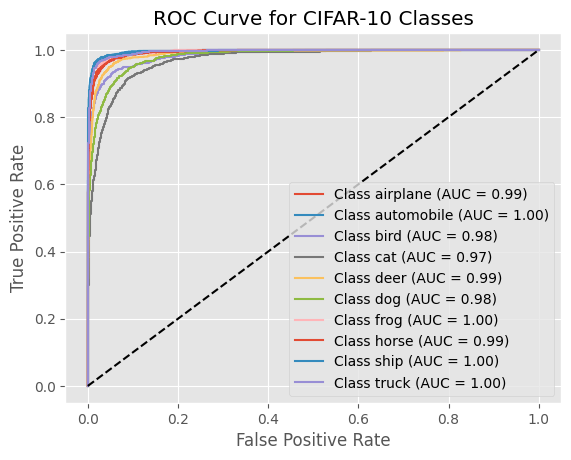

In [17]:
# マルチクラスの場合、ROC曲線の計算のためにラベルをone-hot形式に変換
y_test_binarized = label_binarize(all_labels, classes=range(10))

# 各クラスごとの偽陽性率（FPR）、真陽性率（TPR）、AUCを保存する辞書を用意
fpr = dict()
tpr = dict()
roc_auc = dict()

# 各クラスごとにROC曲線を計算
for i in range(10):
    # 各クラスiについて、真のラベル（one-hot）と予測確率を用いてROCを計算
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], np.array(all_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # ROC曲線からAUC（曲線下面積）を計算

# 各クラスのROC曲線をプロット
plt.figure()
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'Class {trainset.classes[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # ランダム分類器の基準となる対角線
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CIFAR-10 Classes')
plt.legend(loc='lower right')
plt.show()  # グラフを画面に表示